In [89]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.utils.data as Data

import matplotlib.pyplot as plt
from matplotlib import cm
import mpl_toolkits.mplot3d
%matplotlib inline

In [90]:
SEED = 3047

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True


x1, x2 = np.mgrid[-3:3:16j, -3:3:16j]
target = (3*(1-x1)**2)*(np.exp(-x1**2-(x2+1)**2))-(10*(x1/5-x1**3-x2**5))*(np.exp(-x1**2-x2**2))-((1/3)*(np.exp(-(x1+1)**2-x2**2)))
y = (3*(1-x1)**2)*(np.exp(-x1**2-(x2+1)**2))-(10*(x1/5-x1**3-x2**5)) * (np.exp(-x1**2-x2**2))-((1/3)*(np.exp(-(x1+1)**2-x2**2))) 
+ 0.2*np.random.randn(16, 16)

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(projection='3d')
# ax.plot_surface(x1,x2,target,cmap=cm.ocean)
# plt.show()


x11 = x1.reshape(256, 1)  
x22 = x2.reshape(256, 1)
y1 = y.reshape(256, 1)
x = np.append(x11, x22, axis=1)  
x = torch.tensor(x)  
y1 = torch.tensor(y1) 
target = torch.tensor(target)


# validation data
x3, x4 = np.mgrid[-3+0.05:3+0.05:16j, -3+0.05:3+0.05:16j]
validy = (3*(1-x3)**2)*(np.exp(-x3**2-(x4+1)**2))-(10*(x3/5-x3**3-x4**5))*(np.exp(-x3**2-x4**2))-((1/3)*(np.exp(-(x3+1)**2-x4**2)))

x33 = x3.reshape(256, 1)  
x44 = x4.reshape(256, 1)
validy=validy.reshape(256,1)
validx = np.append(x33, x44, axis=1)  
validx = torch.tensor(validx)  
validy = torch.tensor(validy)

# test data
x5, x6 = np.mgrid[-3:3:31j, -3:3:31j]
testy = (3*(1-x5)**2)*(np.exp(-x5**2-(x6+1)**2))-(10*(x5/5-x5**3-x6**5))*(np.exp(-x5**2-x6**2))-((1/3)*(np.exp(-(x5+1)**2-x6**2)))

x55 = x5.reshape(961, 1)  
x66 = x6.reshape(961, 1)
testy=testy.reshape(961,1)
testx = np.append(x55, x66, axis=1)  
testx = torch.tensor(testx)  
testy = torch.tensor(testy)

In [91]:
class custom(nn.Module): 
    
    def __init__(self, width):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1)) 

    def forward(self, input):
        temp=0.5-torch.erf((-input)/self.sigma/1.4142136)/2 
        return temp

In [92]:
class Net(torch.nn.Module): 
    
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  
        self.custom1 = custom(n_hidden1)    
        self.predict = torch.nn.Linear(n_hidden1, n_output)   

    def forward(self, x):  
        x = self.hidden1(x)
        x = self.custom1(x)
        x = self.predict(x)            
        return x

In [103]:
net = Net(n_feature=2, n_hidden1=30, n_output=1)     

device = torch.device('cpu')

optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.96,0.96))
loss_func = torch.nn.MSELoss().to(device)  

epoch=25000

para0=torch.zeros(epoch) 
para1=torch.zeros(epoch) 
para2=torch.tensor([]) 

z=net.custom1.sigma 
nn.init.constant_(z,4)

for t in range(epoch):
    
    net = net.double()
    prediction = net(x)     
    loss = loss_func(prediction, y1)    
    para0[t]=loss.data
    
    optimizer.zero_grad()   
    loss.backward(retain_graph=True)        
    optimizer.step() 
    
    if t%1==0:
        for name, param in net.named_parameters(): 
            if param.requires_grad:
                if name=='custom1.sigma': 
                    temppara2=param.data  
                    para2=torch.cat([para2,temppara2],dim=0) 
    
    if(t)%100 == 99:         
        y_valid = net(validx) 
        lossV = loss_func(y_valid, validy)
        para1[t]=lossV.data 
    
finaly = net(testx) 
finaly=finaly.detach().numpy()
finaly=finaly.reshape(31,31)

C:\Users\HP\AppData\Local\Temp/ipykernel_15880/2002706953.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


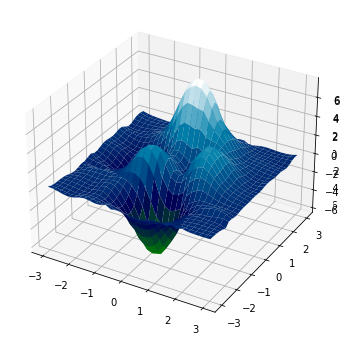

In [104]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(x1, x2, y1, c='r',marker = 'o')
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x5,x6,finaly,cmap=cm.ocean)
plt.show()

C:\Users\HP\AppData\Local\Temp/ipykernel_15880/3736070215.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  k=torch.range(1,epoch)


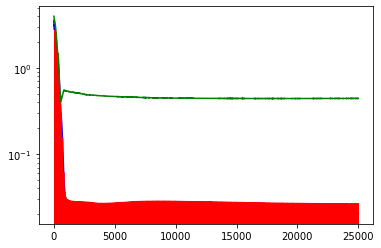

In [105]:
k=torch.range(1,epoch)
plt.plot(k,para0,'b',k,para1,'r',k,para2,'g')
plt.yscale('log')
plt.show()

In [106]:
for name,param in net.named_parameters():
    print(name,param)

hidden1.weight Parameter containing:
tensor([[-8.5053e-01, -8.6813e-01],
        [-2.6720e+00, -2.4862e-02],
        [ 4.6539e-01, -2.3389e-01],
        [ 9.5391e-01, -2.8944e-01],
        [ 5.8902e-02, -1.3448e+00],
        [ 1.1159e+00, -6.4632e-01],
        [ 1.1849e+00,  2.6598e+00],
        [ 1.5796e-01,  1.4745e+00],
        [ 1.1906e+00,  5.6184e+00],
        [-1.1930e+00,  1.6714e-01],
        [ 3.9212e+01,  1.6855e+01],
        [ 5.5002e-01, -1.4564e+00],
        [-5.7468e-01, -1.3744e+00],
        [-1.5658e+00, -3.1659e-01],
        [-6.3798e-01, -4.0545e-01],
        [-5.0852e-01,  1.2734e+00],
        [-1.3208e+00,  4.4119e-01],
        [-8.4766e-01,  1.2522e+00],
        [-1.5365e+00, -6.6189e-02],
        [-9.3463e-02,  1.4268e+00],
        [-6.7608e-01, -1.2263e+00],
        [ 4.6136e-01,  2.7064e-01],
        [ 4.7540e-01, -1.3016e+00],
        [ 4.8032e+00,  2.4650e-01],
        [-1.3465e+01,  4.0127e+00],
        [ 4.6453e+01,  1.3549e+01],
        [-7.1858e-01,  8.53

In [107]:
frame1=pd.DataFrame(para0.data.numpy())
frame1.to_csv('E:/jupyterpath/D2/D2thre_loss_train.csv',index=False)

frame1=pd.DataFrame(para1.data.numpy()) 
frame1.to_csv('E:/jupyterpath/D2/D2thre_loss_valid.csv',index=False)

frame1=pd.DataFrame(para2.data.numpy()) 
frame1.to_csv('E:/jupyterpath/D2/sigma.csv',index=False) 

frame1=pd.DataFrame(x11)  
frame1.to_csv('E:/jupyterpath/D2/x11.csv',index=False) 

frame1=pd.DataFrame(x22) 
frame1.to_csv('E:/jupyterpath/D2/x22.csv',index=False) 

frame1=pd.DataFrame(y1.data.numpy()) 
frame1.to_csv('E:/jupyterpath/D2/y1.csv',index=False) 

frame1=pd.DataFrame(x5) 
frame1.to_csv('E:/jupyterpath/D2/x5.csv',index=False) 

frame1=pd.DataFrame(x6) 
frame1.to_csv('E:/jupyterpath/D2/x6.csv',index=False)

frame1=pd.DataFrame(finaly) 
frame1.to_csv('E:/jupyterpath/D2/finaly.csv',index=False) 